In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['figure.figsize'] = (10, 5)

enrolment_df = pd.read_csv("data/enrolment/clean/enrolment_final.csv", parse_dates=['date'])
demographic_df = pd.read_csv("data/demographic/clean/demographic_final.csv", parse_dates=['date'])
biometric_df = pd.read_csv("data/biometric/clean/biometric_final.csv", parse_dates=['date'])

In [25]:
enrolment_df.head()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,source_file
0,2025-03-02,Meghalaya,East Khasi Hills,793121,11,61,37,api_data_aadhar_enrolment_0_500000.csv
1,2025-03-09,Karnataka,Bengaluru Urban,560043,14,33,39,api_data_aadhar_enrolment_0_500000.csv
2,2025-03-09,Uttar Pradesh,Kanpur Nagar,208001,29,82,12,api_data_aadhar_enrolment_0_500000.csv
3,2025-03-09,Uttar Pradesh,Aligarh,202133,62,29,15,api_data_aadhar_enrolment_0_500000.csv
4,2025-03-09,Karnataka,Bengaluru Urban,560016,14,16,21,api_data_aadhar_enrolment_0_500000.csv


In [26]:
demographic_df.head()

,date,state,district,pincode,demo_age_5_17,demo_age_17_,source_file
0,2025-03-01,Uttar Pradesh,Gorakhpur,273213,49,529,api_data_aadhar_demographic_0_500000.csv
1,2025-03-01,Andhra Pradesh,Chittoor,517132,22,375,api_data_aadhar_demographic_0_500000.csv
2,2025-03-01,Gujarat,Rajkot,360006,65,765,api_data_aadhar_demographic_0_500000.csv
3,2025-03-01,Andhra Pradesh,Srikakulam,532484,24,314,api_data_aadhar_demographic_0_500000.csv
4,2025-03-01,Rajasthan,Udaipur,313801,45,785,api_data_aadhar_demographic_0_500000.csv


In [27]:
biometric_df.head()

,date,state,district,pincode,bio_age_5_17,bio_age_17_,source_file
0,2025-03-01,Haryana,Mahendragarh,123029,280,577,api_data_aadhar_biometric_0_500000.csv
1,2025-03-01,Bihar,Madhepura,852121,144,369,api_data_aadhar_biometric_0_500000.csv
2,2025-03-01,Jammu and Kashmir,Punch,185101,643,1091,api_data_aadhar_biometric_0_500000.csv
3,2025-03-01,Bihar,Bhojpur,802158,256,980,api_data_aadhar_biometric_0_500000.csv
4,2025-03-01,Tamil Nadu,Madurai,625514,271,815,api_data_aadhar_biometric_0_500000.csv


# Feature Engineering

State and Union Territory names exhibited inconsistencies in casing and spelling. These were standardised using rule-based normalisation and manual correction of known variants to ensure accurate geographic aggregation.

In [100]:
def normalize_state_name(s):
    return (
        s.strip()
         .lower()
         .replace('&', 'and')
    )

for df in [enrolment_df, demographic_df, biometric_df]:
    df['state'] = df['state'].astype(str).apply(normalize_state_name)

In [101]:
VALID_STATES = {
    'andaman and nicobar islands',
    'andhra pradesh',
    'arunachal pradesh',
    'assam',
    'bihar',
    'chandigarh',
    'chhattisgarh',
    'dadra and nagar haveli and daman and diu',
    'delhi',
    'goa',
    'gujarat',
    'haryana',
    'himachal pradesh',
    'jammu and kashmir',
    'jharkhand',
    'karnataka',
    'kerala',
    'ladakh',
    'lakshadweep',
    'madhya pradesh',
    'maharashtra',
    'manipur',
    'meghalaya',
    'mizoram',
    'nagaland',
    'odisha',
    'puducherry',
    'punjab',
    'rajasthan',
    'sikkim',
    'tamil nadu',
    'telangana',
    'tripura',
    'uttar pradesh',
    'uttarakhand',
    'west bengal'
}

In [102]:
CITY_TO_STATE = {
    'balanagar': 'telangana',
    'darbhanga': 'bihar',
    'jaipur': 'rajasthan',
    'madanapalle': 'andhra pradesh',
    'nagpur': 'maharashtra',
    'puttenahalli': 'karnataka',
    'raja annamalai puram': 'tamil nadu'
}

In [103]:
JUNK_VALUES = {'100000', 'nan', 'none', ''}

In [104]:
def clean_state(state):
    if pd.isna(state):
        return 'unknown'
    
    s = str(state).strip().lower()
    
    if s in JUNK_VALUES:
        return 'unknown'
    
    if s in CITY_TO_STATE:
        return CITY_TO_STATE[s]
    
    if s in VALID_STATES:
        return s
    
    return 'unknown'

In [105]:
STATE_CORRECTIONS = {
    'westbengal': 'west bengal',
    'west bangal': 'west bengal',
    'odisa': 'odisha',
    'andhra pradesh': 'andhra pradesh',
    'pondicherry': 'puducherry',
    'orissa': 'odisha',
    'uttaranchal': 'uttarakhand',
    'dadra and nagar haveli and daman and diu': 'dadra and nagar haveli and daman and diu',
    'daman & diu': 'dadra and nagar haveli and daman and diu',
    'dadar and nagar haveli': 'dadra and nagar haveli and daman and diu',
    'daman and diu': 'dadra and nagar haveli and daman and diu',
    'west  bengal': 'west bengal',
    'dadra and nagar haveli': 'dadra and nagar haveli and daman and diu',
    'chhatisgarh': 'chhattisgarh',
    'tamilnadu': 'tamil nadu',
    'the dadra and nagar haveli and daman and diu': 'dadra and nagar haveli and daman and diu',
    'the andaman and nicobar islands': 'andaman and nicobar islands',
    'west bengli': 'west bengal',
}

for df in [enrolment_df, demographic_df, biometric_df]:
    df['state'] = df['state'].replace(STATE_CORRECTIONS)

In [106]:
for df in [enrolment_df, demographic_df, biometric_df]:
    df['state'] = df['state'].apply(clean_state)

In [30]:
for df in [enrolment_df, demographic_df, biometric_df]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.to_period('Q').astype(str)

## Geographic Granularity Choice
Analysis is primarily conducted at the state level to ensure consistency, interpretability, and policy relevance. District and pincode-level data are used selectively for outlier exploration and illustration.

Primary level = STATE
Time level = MONTH

In [107]:
enrolment_state_month = (
    enrolment_df
    .groupby(['state', 'year', 'month'], as_index=False)
    [['age_0_5', 'age_5_17', 'age_18_greater']]
    .sum()
)

In [108]:
enrolment_state_month['state'].unique()

array(['andaman and nicobar islands', 'andhra pradesh',
       'arunachal pradesh', 'assam', 'bihar', 'chandigarh',
       'chhattisgarh', 'dadra and nagar haveli and daman and diu',
       'delhi', 'goa', 'gujarat', 'haryana', 'himachal pradesh',
       'jammu and kashmir', 'jharkhand', 'karnataka', 'kerala', 'ladakh',
       'lakshadweep', 'madhya pradesh', 'maharashtra', 'manipur',
       'meghalaya', 'mizoram', 'nagaland', 'odisha', 'puducherry',
       'punjab', 'rajasthan', 'sikkim', 'tamil nadu', 'telangana',
       'tripura', 'unknown', 'uttar pradesh', 'uttarakhand',
       'west bengal'], dtype=object)

In [109]:
demographic_state_month = (
    demographic_df
    .groupby(['state', 'year', 'month'], as_index=False)
    [['demo_age_5_17', 'demo_age_17_']]
    .sum()
)

In [110]:
demographic_state_month['state'].unique()

array(['andaman and nicobar islands', 'andhra pradesh',
       'arunachal pradesh', 'assam', 'bihar', 'chandigarh',
       'chhattisgarh', 'dadra and nagar haveli and daman and diu',
       'delhi', 'goa', 'gujarat', 'haryana', 'himachal pradesh',
       'jammu and kashmir', 'jharkhand', 'karnataka', 'kerala', 'ladakh',
       'lakshadweep', 'madhya pradesh', 'maharashtra', 'manipur',
       'meghalaya', 'mizoram', 'nagaland', 'odisha', 'puducherry',
       'punjab', 'rajasthan', 'sikkim', 'tamil nadu', 'telangana',
       'tripura', 'unknown', 'uttar pradesh', 'uttarakhand',
       'west bengal'], dtype=object)

In [111]:
biometric_state_month = (
    biometric_df
    .groupby(['state', 'year', 'month'], as_index=False)
    [['bio_age_5_17', 'bio_age_17_']]
    .sum()
)

In [112]:
biometric_state_month['state'].unique()

array(['andaman and nicobar islands', 'andhra pradesh',
       'arunachal pradesh', 'assam', 'bihar', 'chandigarh',
       'chhattisgarh', 'dadra and nagar haveli and daman and diu',
       'delhi', 'goa', 'gujarat', 'haryana', 'himachal pradesh',
       'jammu and kashmir', 'jharkhand', 'karnataka', 'kerala', 'ladakh',
       'lakshadweep', 'madhya pradesh', 'maharashtra', 'manipur',
       'meghalaya', 'mizoram', 'nagaland', 'odisha', 'puducherry',
       'punjab', 'rajasthan', 'sikkim', 'tamil nadu', 'telangana',
       'tripura', 'uttar pradesh', 'uttarakhand', 'west bengal'],
      dtype=object)

In [113]:
enrolment_state_month['total_enrolment'] = (
    enrolment_state_month[['age_0_5','age_5_17','age_18_greater']].sum(axis=1)
)

demographic_state_month['total_demo_updates'] = (
    demographic_state_month[['demo_age_5_17','demo_age_17_']].sum(axis=1)
)

biometric_state_month['total_bio_updates'] = (
    biometric_state_month[['bio_age_5_17','bio_age_17_']].sum(axis=1)
)

In [114]:
state_month_df = enrolment_state_month.merge(
    demographic_state_month,
    on=['state','year','month'],
    how='inner'
).merge(
    biometric_state_month,
    on=['state','year','month'],
    how='inner'
)

In [115]:
state_month_df['biometric_to_demo_ratio'] = (
    state_month_df['total_bio_updates'] /
    state_month_df['total_demo_updates'].replace(0, np.nan)
)

state_month_df['adult_enrolment_share'] = (
    state_month_df['age_18_greater'] /
    state_month_df['total_enrolment']
)

# First-Level Plots (Sanity + Direction)

Check:
- Do updates exceed enrolments?
- Any seasonal spikes?

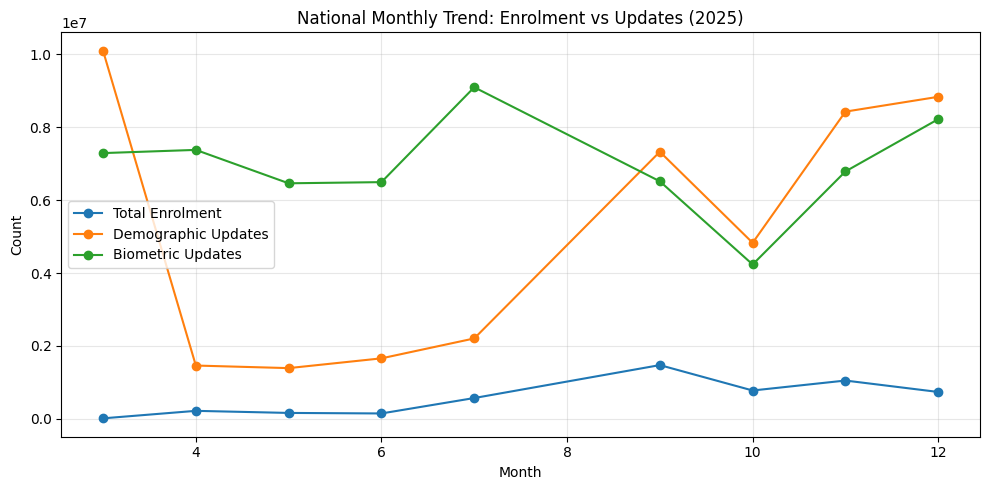

In [137]:
national_trend = state_month_df.groupby(['year','month'], as_index=False)[
    ['total_enrolment','total_demo_updates','total_bio_updates']
].sum()

plt.figure(figsize=(10,5))

plt.plot(
    national_trend['month'],
    national_trend['total_enrolment'],
    label='Total Enrolment',
    marker='o'
)

plt.plot(
    national_trend['month'],
    national_trend['total_demo_updates'],
    label='Demographic Updates',
    marker='o'
)

plt.plot(
    national_trend['month'],
    national_trend['total_bio_updates'],
    label='Biometric Updates',
    marker='o'
)

plt.xlabel("Month")
plt.ylabel("Count")
plt.title("National Monthly Trend: Enrolment vs Updates (2025)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### What we see (objective)
- Demographic and biometric updates are consistently much higher than enrollments
- Enrollment stays comparatively low and stable
- Updates show sharp month-to-month spikes
- Enrolment peaks are smaller and smoother

### What it means (interpretation)
- Aadhaar activity in 2025 is dominated by post-enrolment maintenance, not new registrations
- The system is being used more to correct, update, and re-authenticate identities than to onboard new users
- Aadhaar has moved from an expansion phase to a lifecycle management phase

### Why it matters (policy/system insight)
- IDAI capacity planning should prioritise:
- Update centres
- Authentication infrastructure
- Error handling

Measuring success purely by enrolment numbers is misleading

#### Final: Across all months, demographic and biometric updates significantly exceed new enrollments, indicating Aadhaar’s primary operational load has shifted from expansion to maintenance.

In [117]:
state_summary = (
    state_month_df
    .groupby('state', as_index=False)
    [['total_enrolment','total_bio_updates']]
    .sum()
    .sort_values('total_bio_updates', ascending=False)
)

state_summary.head(20)

,state,total_enrolment,total_bio_updates
33,uttar pradesh,1002631,9367083
20,maharashtra,364496,9023629
19,madhya pradesh,489212,5819736
30,tamil nadu,216604,4572152
4,bihar,547367,4287675
28,rajasthan,342759,3927997
10,gujarat,275042,3151363
15,karnataka,219618,2603652
6,chhattisgarh,99773,2562772
1,andhra pradesh,124273,2503502


In [132]:
state_summary['bio_per_enrolment'] = (
    state_summary['total_bio_updates'] /
    state_summary['total_enrolment']
)

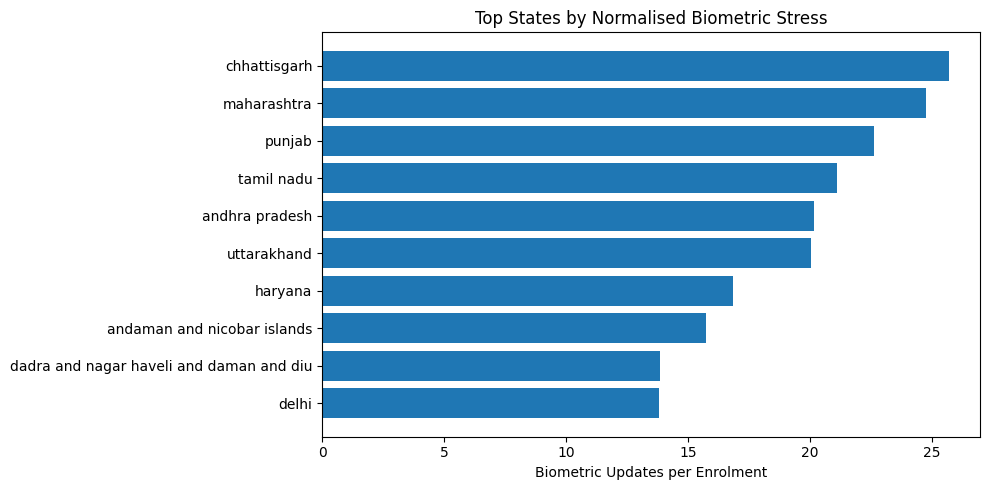

In [ ]:
top_stress = (
    state_summary
    .sort_values('bio_per_enrolment', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
plt.barh(
    top_stress['state'],
    top_stress['bio_per_enrolment']
)

plt.xlabel("Biometric Updates per Enrolment")
plt.title("Top States by Normalised Biometric Stress")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### What we see

- States like Maharashtra, Andhra Pradesh, Tamil Nadu dominate biometric updates
- High biometric updates do not always correspond to highest enrollment
- Some states show very high biometric activity relative to enrollment

### What it means

- High biometric updates are not just population-driven
- These states likely face:
   - Higher biometric failure rates
   - Environmental or occupational wear (manual labour)
   - Quality issues during initial capture
- Aadhaar stress is geographically concentrated

### Why it matters

- A one-size-fits-all national policy will miss these stress pockets
- These states need:
   -   Alternative authentication methods
   -   Targeted infrastructure upgrades
   -   More update camps

#### Final: Biometric update burden is concentrated in a small set of states and is not strictly proportional to enrollment volume, suggesting region-specific operational challenges.

- High stress: Andhra Pradesh, Maharashtra, Tamil Nadu
- Mid: Chattisgarh, Punjab, Haryana
- Low: Andaman & Nicobar Islands, Dadra & Nagar Haveli & Daman & Diu, Uttarakhand

Subsequent deep-dive analysis focuses on a subset of states representing high, medium, and low biometric stress to understand structural differences.

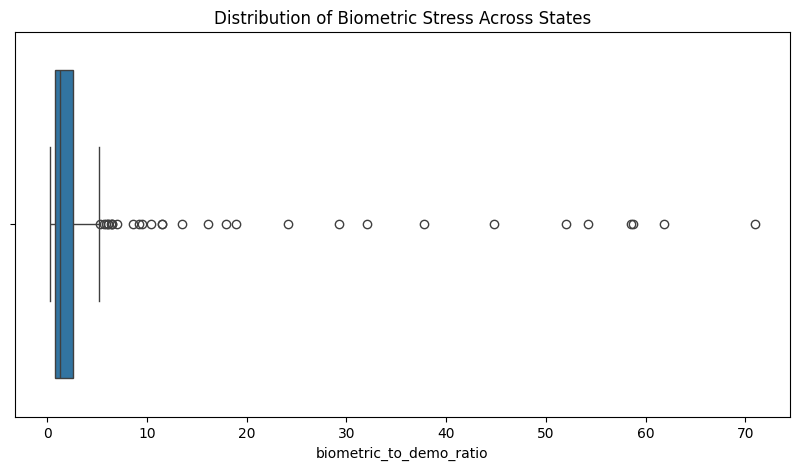

In [119]:
sns.boxplot(
    data=state_month_df,
    x='biometric_to_demo_ratio'
)
plt.title("Distribution of Biometric Stress Across States")
plt.show()

### What we see

- Most states cluster near low biometric_to_demo_ratio
- A long right tail with extreme outliers (ratios up to ~70)
- Very uneven distribution

### What it means

- For most states, biometric updates are a small fraction of demographic updates
- A few states experience disproportionately high biometric stress
- These outliers are systemic anomalies, not noise

### Why it matters

- These outlier states act as early warning signals
- High biometric stress predicts:
    - Authentication failures
    - Exclusion risk
    - Increased grievance load

#### Final: Biometric stress is highly skewed across states, with a small number of states experiencing disproportionately high biometric update intensity.

In [120]:
biometric_state_month['bio_total'] = (
    biometric_state_month['bio_age_5_17'] +
    biometric_state_month['bio_age_17_']
)

biometric_state_month['adult_bio_share'] = (
    biometric_state_month['bio_age_17_'] /
    biometric_state_month['bio_total'].replace(0, np.nan)
)

biometric_state_month['child_bio_share'] = (
    biometric_state_month['bio_age_5_17'] /
    biometric_state_month['bio_total'].replace(0, np.nan)
)

biometric_state_month[['adult_bio_share','child_bio_share']].describe()

,adult_bio_share,child_bio_share
count,324.000000,324.000000
mean,0.518182,0.481818
std,0.124836,0.124836
min,0.144714,0.166904
25%,0.435587,0.402299
50%,0.533471,0.466529
75%,0.597701,0.564413
max,0.833096,0.855286


In [121]:
age_stress_state = (
    biometric_state_month
    .groupby('state', as_index=False)
    [['adult_bio_share','child_bio_share']]
    .mean()
    .sort_values('adult_bio_share', ascending=False)
)

age_stress_state.head(10)

,state,adult_bio_share,child_bio_share
6,chhattisgarh,0.693398,0.306602
24,nagaland,0.685258,0.314742
20,maharashtra,0.625210,0.374790
26,puducherry,0.622195,0.377805
16,kerala,0.605745,0.394255
35,west bengal,0.592921,0.407079
27,punjab,0.589853,0.410147
7,dadra and nagar haveli and daman and diu,0.586116,0.413884
11,haryana,0.575398,0.424602
14,jharkhand,0.571229,0.428771


In [139]:
focus_states = [
    'maharashtra',
    'tamil nadu',
    'chhattisgarh',
    'punjab',
    'andhra pradesh',
    'uttar pradesh',
    'assam'  #lower stress example
]

age_stress_state[age_stress_state['state'].isin(focus_states)]

,state,adult_bio_share,child_bio_share
6,chhattisgarh,0.693398,0.306602
20,maharashtra,0.625210,0.374790
27,punjab,0.589853,0.410147
30,tamil nadu,0.533547,0.466453
1,andhra pradesh,0.424382,0.575618
3,assam,0.394416,0.605584
33,uttar pradesh,0.352269,0.647731


Several high-stress states such as Chhattisgarh, Maharashtra, and Punjab exhibit predominantly adult-driven biometric update activity, indicating elevated authentication friction among working-age populations.

In contrast, states such as Uttar Pradesh, Assam, and Andhra Pradesh show higher child-driven biometric update activity, suggesting Aadhaar interactions linked to schooling and family lifecycle events rather than occupational authentication.

Although Uttar Pradesh and Maharashtra both exhibit high biometric activity, their age-wise profiles differ substantially, highlighting the need for state-specific policy responses.

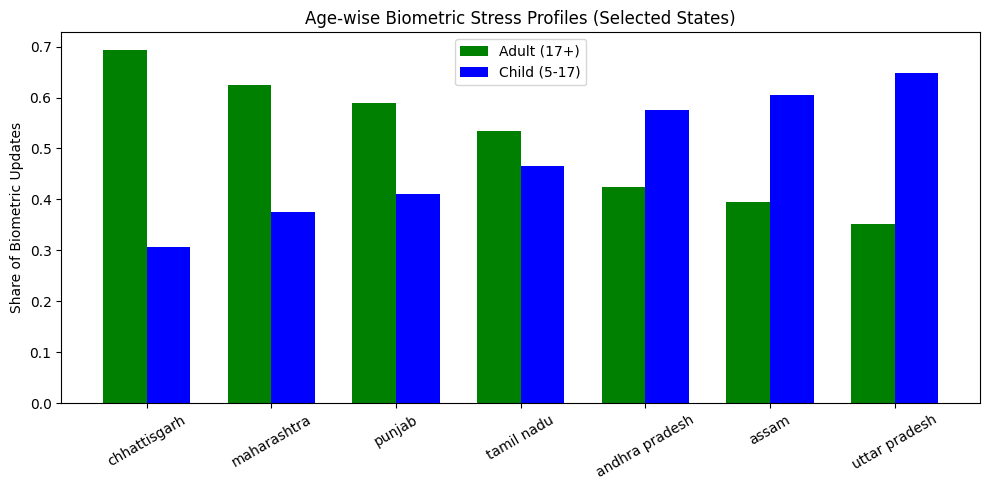

In [143]:
age_focus = age_stress_state[
    age_stress_state['state'].isin(focus_states)
]

x = np.arange(len(age_focus))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(
    x - width/2,
    age_focus['adult_bio_share'],
    width,
    label='Adult (17+)',
    color='green'
)
plt.bar(
    x + width/2,
    age_focus['child_bio_share'],
    width,
    label='Child (5-17)',
    color='blue'
)

plt.xticks(x, age_focus['state'], rotation=30)
plt.ylabel("Share of Biometric Updates")
plt.title("Age-wise Biometric Stress Profiles (Selected States)")
plt.legend()
plt.tight_layout()
plt.show()


In [123]:
monthly_stress = (
    state_month_df
    .groupby('month', as_index=False)
    ['biometric_to_demo_ratio']
    .mean()
)

In [124]:
biometric_state_month.groupby('state')[
    ['adult_bio_share']
].mean().sort_values('adult_bio_share', ascending=False).head()

,adult_bio_share
state,
chhattisgarh,0.693398
nagaland,0.685258
maharashtra,0.625210
puducherry,0.622195
kerala,0.605745


In [126]:
import os
os.makedirs("intermediate", exist_ok=True)

state_month_df.to_csv("intermediate/state_month_df.csv", index=False)
state_summary.to_csv("intermediate/state_summary.csv", index=False)
age_stress_state.to_csv("intermediate/age_stress_state.csv", index=False)
biometric_df.to_csv("intermediate/biometric_data.csv", index=False)